# Suicide Rates

The data science blog will use the kaggle data set __Suicide Rates Overview__ which compares socio-economic info with suicide rates by year and country https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016.

Key questions:
1. Are you statistical suicidal? E.g, who is the most suicidal?
2. Do GDP, HDI and population impact suicide rates?

Let's start by importing the CSV file into a __pandas.DataFrame__ and take a first look at the data.

In [2]:
import pandas as pd


# note that the CSV file needs to be in the same location as your notebook
df = pd.read_csv('suicide_data.csv')
# return the first 5 rows of the data frame
df.head()

,country,year,sex,age,suicides,population,hdi,gdp,generation
0,Albania,1987,male,15-24 years,21,312900,NaN,796,Generation X
1,Albania,1987,male,35-54 years,16,308000,NaN,796,Silent
2,Albania,1987,female,15-24 years,14,289700,NaN,796,Generation X
3,Albania,1987,male,75+ years,1,21800,NaN,796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,NaN,796,Boomers


The data appears to be well structured and consistent. The data frame method __pandas.DataFrame.info()__ provides more details on the data.

In [3]:
# prints information about the data frame including the index dtype and column dtypes, non-null values and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 9 columns):
country       27820 non-null object
year          27820 non-null int64
sex           27820 non-null object
age           27820 non-null object
suicides      27820 non-null int64
population    27820 non-null int64
hdi           8364 non-null float64
gdp           27820 non-null int64
generation    27820 non-null object
dtypes: float64(1), int64(4), object(4)
memory usage: 1.9+ MB


__Oberservations__:
1. The data frame consists off 9 columns and 27820 rows.
2. All data types are already correct.
3. Column 'hdi' has lots of __missing values__.

The missing HDI's will be complemented by the information of the United Nations Development Programme (http://hdr.undp.org/en/data) and the backfill method. The backfill method uses the next valid observation to fill the gap of missing values. This approach is especially usefull for ordered time series data.

In [164]:
# import the HDI CSV file with the correct encoding
hdi = pd.read_csv('hdi_data.csv', encoding='latin-1')
# change the format of the data frame such that the column 'year' replaces the columns '1985', '1986', ..., '2017'
hdi = hdi.melt(id_vars='Country', var_name='year', value_name='value')
# convert data type of column 'year' from string to integer
hdi.year = hdi.year.apply(int)

# note that this loop may take a while (~ 10-30 seconds)
for i in df.loc[pd.isna(df['hdi']), :].index:
    # set the missing hdi value in df equal to the corresponding (country & year match) value in hdi
    df.at[i, 'hdi'] = hdi[(hdi['Country']==df['country'].iloc[i]) & (hdi['year']==df['year'].iloc[i])].value.values[0]

# apply the backfill method to clean up the remaining missing values which could not be found in the hdi data frame
df.fillna(method='backfill', inplace=True)

In [113]:
# group the data by country and take the mean of the number of suicides and population, respectively
suicides_per_country = df.groupby(by=['country'])['suicides'].mean()
population_per_country = df.groupby(by=['country'])['population'].mean()
# calculate the ratio and store the ordered results in a data frame
data = pd.DataFrame((suicides_per_country / population_per_country).sort_values(ascending=False))

Populating the interactive namespace from numpy and matplotlib


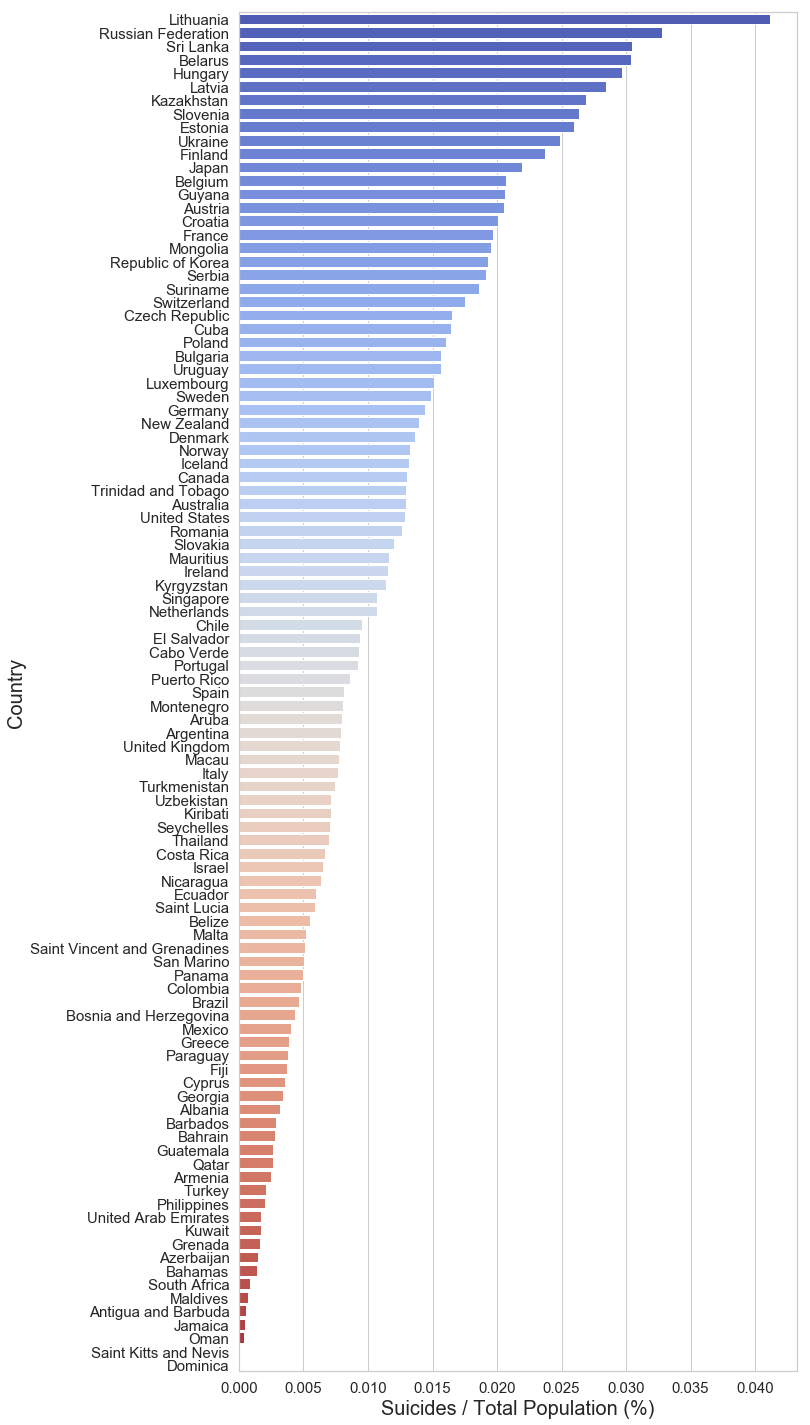

In [114]:
%matplotlib inline 
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 25)
barplot = sns.barplot(x=data[0] * 100, y=data.index, orient='h', palette='coolwarm')
barplot.set_ylabel('Country',fontsize=20)
barplot.set_xlabel('Suicides / Total Population (%)',fontsize=20)
barplot.tick_params(labelsize=15)